# Stroke Risk
## Analysis and Machine Learning model

In [35]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
import psycopg2

### Importing the data

In [36]:
from config import db_password, db_url, db_port

# Make a connection
connection_string = f"postgres://postgres:{db_password}@{db_url}:{db_port}/final_project"
engine = create_engine(connection_string)

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
CleanData = Base.classes.clean_data
session = Session(engine)


In [38]:
# load the data
query = session.query(CleanData)
stroke_df = pd.read_sql(query.statement, engine)
stroke_df.head()

,id,age,current_smoker,stroke,hypertension,bmi,avg_glucose_level,gender
0,1,39.0,0,0,0,26.97,77,Male
1,2,46.0,0,0,0,28.73,76,Female
2,3,48.0,1,0,0,25.34,70,Male
3,4,61.0,1,0,1,28.58,103,Female
4,5,46.0,1,0,0,23.10,85,Female


In [39]:
# Do some data cleaning to prepare it for database save.
stroke_df['clean_data_id'] = stroke_df['id']
stroke_df.head()

,id,age,current_smoker,stroke,hypertension,bmi,avg_glucose_level,gender,clean_data_id
0,1,39.0,0,0,0,26.97,77,Male,1
1,2,46.0,0,0,0,28.73,76,Female,2
2,3,48.0,1,0,0,25.34,70,Male,3
3,4,61.0,1,0,1,28.58,103,Female,4
4,5,46.0,1,0,0,23.10,85,Female,5


In [40]:
# remove columns that are not useful to the analysis part.
clean_stroke_df = stroke_df.drop(columns=['id', 'clean_data_id'])

## Data Inspection

In [41]:
# Quick glance at what single variable has the highest correlation with a stroke
clean_stroke_df.corr()['stroke']\
    .sort_values(ascending=False)

stroke               1.000000
age                  0.209085
avg_glucose_level    0.154663
bmi                  0.054233
hypertension         0.051949
clean_data_id       -0.012881
current_smoker      -0.051091
Name: stroke, dtype: float64

<AxesSubplot:>

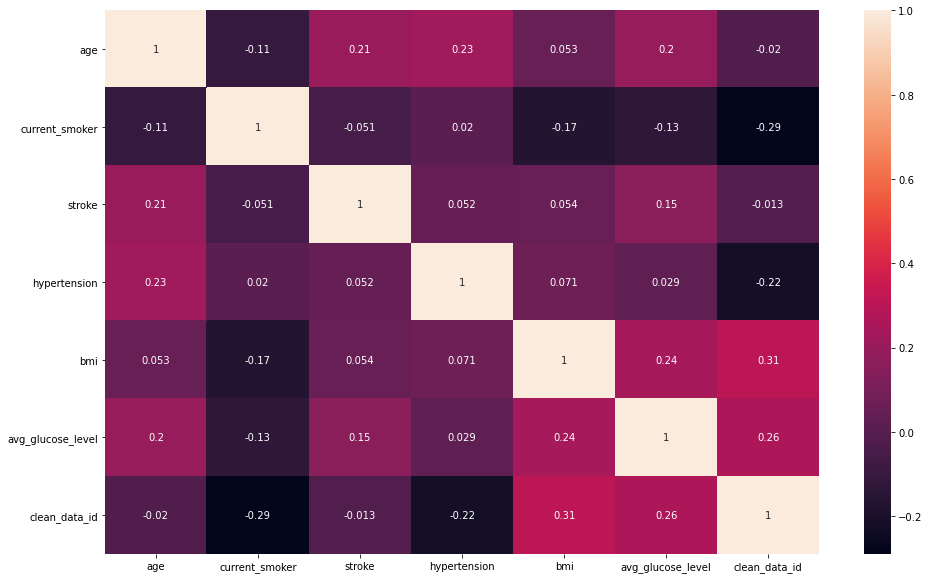

In [42]:
# Visualize the correlations.
import seaborn as sb
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
sb.heatmap(clean_stroke_df.corr(), annot=True)

### Quick analysis 

A quick glance shows that age seems to be the most correlated with having a stroke.

## Prepare to build a supervised neural network model

In [43]:
# Determine the number of unique values in each column.
clean_stroke_df.nunique()

age                    65
current_smoker          2
stroke                  2
hypertension            2
bmi                  1573
avg_glucose_level     231
gender                  3
clean_data_id        7909
dtype: int64

### Possible binning fields

- work_type

In [44]:
# Look at work_type value counts for binning
work_type_counts = clean_stroke_df.work_type.value_counts()
work_type_counts

AttributeError: 'DataFrame' object has no attribute 'work_type'

<AxesSubplot:ylabel='Density'>

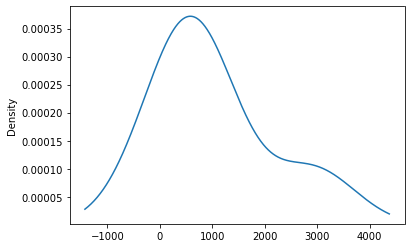

In [8]:
work_type_counts.plot.density()

Looks like there isn't binning worth in work_types field

## Classify the data

In [31]:
# Generate categorical variable list
stroke_cat = stroke_df.dtypes[stroke_df.dtypes == "object"].index.tolist()

In [32]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(stroke_df[stroke_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(stroke_cat)
encode_df.head()

,gender_Female,gender_Male,gender_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [49]:
# Merge one-hot encoded features and drop the originals
scaled_stroke_df = stroke_df.merge(encode_df, left_index=True, right_index=True)
scaled_stroke_df.head()
scaled_stroke_df = scaled_stroke_df.drop(stroke_cat, 1)
scaled_stroke_df.head()

,age,current_smoker,stroke,hypertension,bmi,avg_glucose_level,clean_data_id,gender_Female,gender_Male,gender_Other
0,39.0,0,0,0,26.97,77,1,0.0,1.0,0.0
1,46.0,0,0,0,28.73,76,2,1.0,0.0,0.0
2,48.0,1,0,0,25.34,70,3,0.0,1.0,0.0
3,61.0,1,0,1,28.58,103,4,1.0,0.0,0.0
4,46.0,1,0,0,23.10,85,5,1.0,0.0,0.0


In [50]:
# Save the scaled data to the database for later use.

# Delete tables if existing
with engine.connect() as con:
        con.execute('DROP TABLE IF EXISTS scaled_data;')

# Create the tables
with engine.connect() as con:
    sql = """
    CREATE TABLE "scaled_data" (
        "id" serial   NOT NULL,
        "clean_data_id" int   NOT NULL,
        "age" float   NOT NULL,
        "current_smoker" int   NOT NULL,
        "stroke" int   NOT NULL,
        "hypertension" int   NOT NULL,
        "bmi" float   NOT NULL,
        "avg_glucose_level" int   NOT NULL,
        "gender_Female" int   NOT NULL,
        "gender_Male" int   NOT NULL,
        "gender_Other" int   NOT NULL,
        CONSTRAINT "pk_scaled_data" PRIMARY KEY (
            "id"
        )
    );

    ALTER TABLE "scaled_data" ADD CONSTRAINT "fk_scaled_data_clean_data_id" FOREIGN KEY("clean_data_id")
    REFERENCES "clean_data" ("id");
    """
    engine.execute(sql)
scaled_stroke_df.to_sql(name='scaled_data', con=engine, if_exists="append", index=False)
print('Scaled Data inserted')

ProgrammingError: (psycopg2.errors.UndefinedColumn) column "gender" of relation "scaled_data" does not exist
LINE 1: ...er, stroke, hypertension, bmi, avg_glucose_level, gender, cl...
                                                             ^

[SQL: INSERT INTO scaled_data (age, current_smoker, stroke, hypertension, bmi, avg_glucose_level, gender, clean_data_id) VALUES (%(age)s, %(current_smoker)s, %(stroke)s, %(hypertension)s, %(bmi)s, %(avg_glucose_level)s, %(gender)s, %(clean_data_id)s)]
[parameters: ({'age': 39.0, 'current_smoker': 0, 'stroke': 0, 'hypertension': 0, 'bmi': 26.97, 'avg_glucose_level': 77, 'gender': 'Male', 'clean_data_id': 1}, {'age': 46.0, 'current_smoker': 0, 'stroke': 0, 'hypertension': 0, 'bmi': 28.73, 'avg_glucose_level': 76, 'gender': 'Female', 'clean_data_id': 2}, {'age': 48.0, 'current_smoker': 1, 'stroke': 0, 'hypertension': 0, 'bmi': 25.34, 'avg_glucose_level': 70, 'gender': 'Male', 'clean_data_id': 3}, {'age': 61.0, 'current_smoker': 1, 'stroke': 0, 'hypertension': 1, 'bmi': 28.58, 'avg_glucose_level': 103, 'gender': 'Female', 'clean_data_id': 4}, {'age': 46.0, 'current_smoker': 1, 'stroke': 0, 'hypertension': 0, 'bmi': 23.1, 'avg_glucose_level': 85, 'gender': 'Female', 'clean_data_id': 5}, {'age': 43.0, 'current_smoker': 0, 'stroke': 0, 'hypertension': 1, 'bmi': 30.3, 'avg_glucose_level': 99, 'gender': 'Female', 'clean_data_id': 6}, {'age': 63.0, 'current_smoker': 0, 'stroke': 0, 'hypertension': 0, 'bmi': 33.11, 'avg_glucose_level': 85, 'gender': 'Female', 'clean_data_id': 7}, {'age': 45.0, 'current_smoker': 1, 'stroke': 0, 'hypertension': 0, 'bmi': 21.68, 'avg_glucose_level': 78, 'gender': 'Female', 'clean_data_id': 8}  ... displaying 10 of 7909 total bound parameter sets ...  {'age': 51.0, 'current_smoker': 0, 'stroke': 0, 'hypertension': 0, 'bmi': 25.6, 'avg_glucose_level': 166, 'gender': 'Male', 'clean_data_id': 7908}, {'age': 44.0, 'current_smoker': 0, 'stroke': 0, 'hypertension': 0, 'bmi': 26.2, 'avg_glucose_level': 85, 'gender': 'Female', 'clean_data_id': 7909})]
(Background on this error at: http://sqlalche.me/e/13/f405)

In [ ]:
# remove the foreign key for model building
scaled_stroke_df = scaled_stroke_df.drop(columns=["clean_data_id"])

## Build the model

In [12]:
# Split our preprocessed data into our features and target arrays
y = scaled_stroke_df.stroke
X = stroke_df.drop(columns=['stroke'])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [13]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
# Create a checkpoint of the model
checkpoint_filepath = 'resources/model/checkpoints/stroke_data_analysis.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy', 
    mode='max',
    save_best_only=True,
    save_freq=5,
    verbrose=1
)

In [15]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    Dense(
        units=number_input_features * 2,
        input_dim=number_input_features,
        activation='relu'
    )
)

# Second hidden layer
nn.add(
    Dense(
        units=number_input_features,
        activation='relu'
    )
)

# Output layer
nn.add(
    Dense(
        units=1,
        activation='sigmoid'
    )
)

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                924       
_________________________________________________________________
dense_1 (Dense)              (None, 21)                903       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 22        
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

# Fit the model
nn.fit(
    X_train_scaled, 
    np.asarray(y_train), 
    epochs=100,
    callbacks=checkpoint_callback
)

Epoch 1/100
120/120 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.9491
Epoch 2/100
120/120 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9496
Epoch 3/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 4/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 5/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 6/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 7/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 8/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 9/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 10/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 11/100
120/12

In [17]:
# The model weights (that are considered the best) are loaded into the model.
nn.load_weights(checkpoint_filepath)

# Check accuracy
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

40/40 - 0s - loss: nan - accuracy: 0.9562
Loss: nan, Accuracy: 0.956181526184082


In [18]:
# Save the model
nn.save('resources/model/stroke_data_analysis.h5')

## Summary